In [13]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes
# %reload_ext autoreload
from source.kinetic_mechanisms.JaxKineticMechanisms import *
from source.kinetic_mechanisms.JaxKineticMechanismsCustom import *
from source.kinetic_mechanisms.JaxKineticModifiers import *

## set up a small term system for state variables
# S=pd.DataFrame(np.array([[-1,1,2]]),index=['ICglucose'],columns=['v_GLT','v_HXK','v_NTH1'])
import diffrax
import numpy as np

# S=pd.DataFrame(np.array([[1,-1]]),index=['ICglucose'],columns=['v_GLT','v_HXK'])

import matplotlib.pyplot as plt
import pandas as pd

import jax

jax.config.update("jax_enable_x64", True)

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


In [14]:
def overwrite_y0_dict(y0_dict, dataset):
    """Overwrites the y0 dictionary with the values from the dataset"""
    ynew_dict = y0_dict.copy()
    dataset_iv = dataset.to_dict()

    for met in ynew_dict.keys():
        if met in dataset_iv.keys():
            ynew_dict[met] = dataset_iv[met]

    return ynew_dict

In [15]:
GLT_params = {"p_GLT_KmGLTGLCi": 1.1918, "p_GLT_KmGLTGLCo": 1.0078, "p_GLT_VmGLT": 0.734}
HXK1_params = {
    "p_HXK1_Kadp": 0.23,
    "p_HXK1_Katp": 0.15,
    "p_HXK1_Keq": 3800,
    "p_HXK1_Kg6p": 30,
    "p_HXK1_Kglc": 0.08,
    "p_HXK1_Kt6p": 0.2,
    "p_HXK_Vmax": 1 * 0.95 * (1 + 0),
}
NTH1_params = {"p_NTH1_Ktre": 2.88, "p_NTH1_kcat": 100, "f_NTH1": 0.0020, "p_NTH1_Vmax": 100 * 0.0020}

PGI_params = {"p_PGI1_Keq": 0.2586, "p_PGI1_Kf6p": 0.307, "p_PGI1_Kg6p": 1.0257, "p_PGI1_Vmax": 1 * 13.4667 * 1}

PGM1_params = {"p_PGM1_Keq": 0.166666666666667, "p_PGM1_Kg1p": 0.023, "p_PGM1_Kg6p": 0.05, "p_PGM1_Vmax": 100}


TPS1_params = {"p_TPS1_Kg6p": 3.8, "p_TPS1_Kudp_glc": 0.886, "p_TPS1_Kpi": 1, "p_TPS1_KmF6P": 1, "p_TPS1_Vmax": 1000 * 0.0014}
TPS2_params = {"p_TPS2_Kt6p": 0.5, "p_TPS2_Kpi": 0.7023, "p_TPS2_Vmax": 81.45 * 0.0013}  # Calculated value for p_TPS2_Vmax


UGP_params = {"f_UGP1": 3.1000e-04}


PFK_params = {
    "p_PFK_Camp": 0.0845,
    "p_PFK_Catp": 3,
    "p_PFK_Cf16bp": 0.397,
    "p_PFK_Cf26bp": 0.0174,
    "p_PFK_Ciatp": 100,
    "p_PFK_Kamp": 0.095,
    "p_PFK_Katp": 0.71,
    "p_PFK_Kf16bp": 0.111,
    "p_PFK_Kf26bp": 0.0012,
    "p_PFK_Kf6p": 0.1,
    "p_PFK_Kiatp": 0.65,
    "p_PFK_L": 0.66,
    "p_PFK_gR": 5.12,
    "p_PFK_F26BP": 1e-3,
    "p_PFK_Vmax": 1 * 0.71 * 1,  # Calculated as p_PFK_ExprsCor * p_PFK_kcat * f_PFK
}


ALD_params = {
    "p_FBA1_Kdhap": 2.4,
    "p_FBA1_Keq": 0.069,
    "p_FBA1_Kf16bp": 0.451,
    "p_FBA1_Kglyceral3p": 2,
    "p_FBA1_Vmax": 3.15 * 1,
}  # Calculated as p_FBA1_kcat * f_FBA1}


TPI1_params = {"p_TPI1_Kdhap": 6.45, "p_TPI1_Keq": 0.0391, "p_TPI1_Kglyceral3p": 5.25, "p_TPI1_Vmax": 78.396}


G3PDH_params = {
    "p_GPD1_Kadp": 2,
    "p_GPD1_Katp": 0.73,
    "p_GPD1_Kdhap": 0.54,
    "p_GPD1_Keq": 10000,
    "p_GPD1_Kf16bp": 4.8,
    "p_GPD1_Kglyc3p": 1.2,
    "p_GPD1_Knad": 0.93,
    "p_GPD1_Knadh": 0.023,
    "p_GPD1_Vmax": 1.169 * 1,
}

PGK_params = {
    "p_PGK_KeqPGK": 3200,
    "p_PGK_KmPGKADP": 0.2,
    "p_PGK_KmPGKATP": 0.3,
    "p_PGK_KmPGKBPG": 0.003,
    "p_PGK_KmPGKP3G": 0.53,
    "p_PGK_VmPGK": 44.5,
    "p_PGK_ExprsCor": 1,
}


GAPDH_params = {
    "p_TDH1_Keq": 0.0056,
    "p_TDH1_Kglyceral3p": 0.459,
    "p_TDH1_Kglycerate13bp": 0.908,
    "p_TDH1_Knad": 2.92,
    "p_TDH1_Knadh": 0.022,
    "p_TDH1_Kpi": 1.5,
    "p_GAPDH_Vmax": 1 * 30.98 * (1 + 0 + 0),  # p_GAPDH_ExprsCor * p_TDH1_kcat * (f_TDH1 + f_TDH2 + f_TDH3)
}

vsink3PGA_params = {"poly_sinkP3G": 1e-03, "km_sinkP3G": 0.007881000000000}  # reverse the sink sign, otherwise it doesnt work

# MODELLING REACTION


HOR2_params = {"p_HOR2_Kglyc3p": 5.99, "p_HOR2_Kpi": 1, "p_HOR2_Vmax": 0.5 * 1}

GlycT_params = {"p_GlycerolTransport": 0.100, "f_GLYCEROL_e": 0.1}

PGM_params = {"p_PGM_K2pg": 0.08, "p_PGM_K3pg": 1.2, "p_PGM_Keq": 0.19, "p_PGM_Vm": 14.2667}

ENO1_params = {"p_ENO1_K2pg": 0.043, "p_ENO1_Keq": 4.011, "p_ENO1_Kpep": 0.5, "p_ENO1_Vm": 5.95}


PYK1_params = {
    "p_PYK1_Kadp": 0.2430,
    "p_PYK1_Katp": 9.3000,
    "p_PYK1_Kf16bp": 0.2,
    "p_PYK1_Kpep": 0.2810,
    "p_PYK1_L": 60000,
    "p_PYK1_hill": 4,
    "p_PYK1_Vm": 9.3167,
}

PDC_params = {"p_PDC1_Kpi": 14.7, "p_PDC1_Kpyr": 8.5, "p_PDC1_hill": 1.9, "p_PDC1_Vmax": 1 * 12.2 * 0.5290}
# }
ADH_params = {
    "p_ADH_KeqADH": 0.000069,
    "p_ADH_KiADHACE": 1.1,
    "p_ADH_KiADHETOH": 90,
    "p_ADH_KiADHNAD": 0.92,
    "p_ADH_KiADHNADH": 0.031,
    "p_ADH_KmADHACE": 1.11,
    "p_ADH_KmADHETOH": 17,
    "p_ADH_KmADHNAD": 0.17,
    "p_ADH_KmADHNADH": 0.11,
    "p_ADH_VmADH": 13.5,
    "p_ADH_ExprsCor": 1,
}

mito_params = {"p_mitoVmax": 1, "p_mitoADPKm": 0.5, "p_mitoPiKm": 1}
ATPase_params = {"p_ATPase_ratio": 0.12}  # might be adjusted on perturbation

# mitonadh
mitoNADH_params = {"p_mitoNADHVmax": 1, "p_mitoNADHKm": 0.1}


vsinkPEP_params = {"km_sinkPEP": 1e-03}  # reverse stoichiometry
vsinkACE_params = {"km_sinkACE": 1e-04}  # reverse stoichiometry
vsinkPYR_params = {"km_sinkPYR": 1e-03}  # reverse stoichiometry
vsink3PGA_params = {"km_sinkP3G": 1e-03}  # reverse the sink sign, otherwise it doesnt work
v_sinkG6P_params = {"km_sinkG6P": 1e-02}  # reverse stoichiometry
v_sinkF6P_params = {"km_sinkF6P": 1e-04}  # poly sinks are not learned anymore
v_sinkGAP = {"poly_sinkGAP": 0.012626, "km_sinkGAP": 5e-04}


UGP_params = {"flux_ugp": 3.1000e-04}
ETOH_params = {"p_kETOHtransport": 0.1, "f_ETOH_e": 0.00001}

ADK1_params = {"p_ADK1_k": 100, "p_ADK1_Keq": 0.45}
VacPi_params = {"p_vacuolePi_k": 0.17, "p_vacuolePi_steadyStatePi": 10}
AMD1_params = {"p_Amd1_K50": 10.9184, "p_Amd1_Kpi": 1.6184e03, "p_Amd1_Katp": 5000, "p_Amd1_Vmax": 4}

ADE_params = {"p_Ade13_Ade12_k": 0.05}  # is not constant!!!!!!!!!!!!!!
ISN1_params = {"p_Isn1_k": 0.1}  # or 0
PNP1_params = {"p_Pnp1_k": 0.03}  # or 0
HPT1_params = {"p_Hpt1_k": 0.02}  # or 0


params = {
    **GLT_params,
    **HXK1_params,
    **NTH1_params,
    **NTH1_params,
    **PGI_params,
    **v_sinkG6P_params,
    **PGM1_params,
    **TPS1_params,
    **TPS2_params,
    **v_sinkF6P_params,
    **UGP_params,
    **PFK_params,
    **ALD_params,
    **v_sinkGAP,
    **TPI1_params,
    **G3PDH_params,
    **GAPDH_params,
    **PGK_params,
    **vsink3PGA_params,
    **HOR2_params,
    **GlycT_params,
    **PGM_params,
    **ENO1_params,
    **vsinkPEP_params,
    **vsinkPEP_params,
    **PYK1_params,
    **vsinkPYR_params,
    **PDC_params,
    **ADH_params,
    **vsinkACE_params,
    **ETOH_params,
    **mitoNADH_params,
    **UGP_params,
    **mito_params,
    **ATPase_params,
    **ADK1_params,
    **VacPi_params,
    **AMD1_params,
    **ADE_params,
    **ISN1_params,
    **PNP1_params,
    **HPT1_params,
}  # remove v_sinkF16P


print("n_parameters", len(params))


##
v_GLT = Jax_Facilitated_Diffusion(
    substrate_extracellular="ECglucose",
    product_intracellular="ICglucose",
    vmax="p_GLT_VmGLT",
    km_internal="p_GLT_KmGLTGLCi",
    km_external="p_GLT_KmGLTGLCo",
)

v_HXK = Jax_MM_Rev_BiBi_w_Inhibition(
    substrate1="ICATP",
    substrate2="ICglucose",
    product1="ICADP",
    product2="ICATP",
    modifier="ICT6P",
    vmax="p_HXK_Vmax",
    k_equilibrium="p_HXK1_Keq",
    km_substrate1="p_HXK1_Katp",
    km_substrate2="p_HXK1_Kglc",
    km_product1="p_HXK1_Kadp",
    km_product2="p_HXK1_Kg6p",
    ki_inhibitor="p_HXK1_Kt6p",
)


v_NTH1 = Jax_MM_Irrev_Uni(substrate="ICtreh", vmax="p_NTH1_Vmax", km_substrate="p_NTH1_Ktre")
v_PGI = Jax_MM_Rev_UniUni(
    substrate="ICG6P",
    product="ICF6P",
    vmax="p_PGI1_Vmax",
    k_equilibrium="p_PGI1_Keq",
    km_substrate="p_PGI1_Kg6p",
    km_product="p_PGI1_Kf6p",
)
v_sinkG6P = Jax_MM_Sink(substrate="ICG6P", v_sink="poly_sinkG6P", km_sink="km_sinkG6P")
v_sinkF6P = Jax_MM_Sink(substrate="ICF6P", v_sink="poly_sinkF6P", km_sink="km_sinkF6P")
v_PGM1 = Jax_MM_Rev_UniUni(
    substrate="ICG1P",
    product="ICG6P",
    vmax="p_PGM1_Vmax",
    k_equilibrium="p_PGM1_Keq",
    km_substrate="p_PGM1_Kg1p",
    km_product="p_PGM1_Kg6p",
)  # to do v_TPS1 for 2nd rate law

# inhibitor_TPS1=SimpleInhibitor(k_I='p_TPS1_Kpi')
activator_TPS1 = SimpleActivator(k_A="p_TPS1_KmF6P")
v_TPS1 = Jax_MM_Irrev_Bi_w_Modifiers(
    substrate1="ICG6P",
    substrate2="ICG1P",
    modifiers_list=["ICF6P"],
    vmax="p_TPS1_Vmax",
    km_substrate1="p_TPS1_Kg6p",
    km_substrate2="p_TPS1_Kudp_glc",
    modifiers=[activator_TPS1],
)

# v_TPS1=Jax_MM_Irrev_Bi(substrate1="ICG6P",substrate2="ICG1P",vmax="p_TPS1_Vmax",km_substrate1="p_TPS1_Kg6p",km_substrate2="p_TPS1_Kudp_glc")
v_TPS2 = Jax_MM_Irrev_Bi_w_Inhibition(
    substrate="ICT6P", product="ICPHOS", vmax="p_TPS2_Vmax", km_substrate1="p_TPS2_Kt6p", ki="p_TPS2_Kpi"
)


v_PFK = Jax_PFK(
    substrate1="ICF6P",
    substrate2="ICATP",
    product1="ICFBP",
    modifier="ICAMP",
    vmax="p_PFK_Vmax",
    kr_F6P="p_PFK_Kf6p",
    kr_ATP="p_PFK_Katp",
    gr="p_PFK_gR",
    c_ATP="p_PFK_Catp",
    ci_ATP="p_PFK_Ciatp",
    ci_AMP="p_PFK_Camp",
    ci_F26BP="p_PFK_Cf26bp",
    ci_F16BP="p_PFK_Cf16bp",
    l="p_PFK_L",
    kATP="p_PFK_Kiatp",
    kAMP="p_PFK_Kamp",
    F26BP="p_PFK_F26BP",
    kF26BP="p_PFK_Kf26bp",
    kF16BP="p_PFK_Kf16bp",
)
v_ALD = Jax_MM_Rev_UniBi(
    substrate="ICFBP",
    product1="ICGAP",
    product2="ICDHAP",
    vmax="p_FBA1_Vmax",
    k_equilibrium="p_FBA1_Keq",
    km_substrate="p_FBA1_Kf16bp",
    km_product1="p_FBA1_Kglyceral3p",
    km_product2="p_FBA1_Kdhap",
)
v_TPI1 = Jax_MM_Rev_UniUni(
    substrate="ICDHAP",
    product="ICGAP",
    vmax="p_TPI1_Vmax",
    k_equilibrium="p_TPI1_Keq",
    km_substrate="p_TPI1_Kdhap",
    km_product="p_TPI1_Kglyceral3p",
)
v_sinkGAP = Jax_MM_Sink(substrate="ICGAP", v_sink="poly_sinkGAP", km_sink="km_sinkGAP")
v_G3PDH = Jax_MM_Rev_BiBi_w_Activation(
    substrate1="ICDHAP",
    substrate2="ICNADH",
    product1="ICG3P",
    product2="ICNAD",
    modifiers=["ICFBP", "ICATP", "ICADP"],
    vmax="p_GPD1_Vmax",
    k_equilibrium="p_GPD1_Keq",
    km_substrate1="p_GPD1_Kdhap",
    km_substrate2="p_GPD1_Knadh",
    km_product1="p_GPD1_Kglyc3p",
    km_product2="p_GPD1_Knad",
    ka1="p_GPD1_Kf16bp",
    ka2="p_GPD1_Katp",
    ka3="p_GPD1_Kadp",
)
v_GAPDH = Jax_MM_Ordered_Bi_Tri(
    substrate1="ICGAP",
    substrate2="ICNAD",
    substrate3="ICPHOS",
    product1="ICBPG",
    product2="ICNADH",
    vmax="p_GAPDH_Vmax",
    k_equilibrium="p_TDH1_Keq",
    km_substrate1="p_TDH1_Kglyceral3p",
    km_substrate2="p_TDH1_Knad",
    ki="p_TDH1_Kpi",
    km_product1="p_TDH1_Kglycerate13bp",
    km_product2="p_TDH1_Knadh",
)  # might exchange this mechanism by a BiBi mechanism, since modeling Phos is a bit too much
v_PGK = Jax_MM_Rev_BiBi(
    substrate1="ICBPG",
    substrate2="ICADP",
    product1="IC3PG",
    product2="ICATP",
    vmax="p_PGK_VmPGK",
    k_equilibrium="p_PGK_KeqPGK",
    km_substrate1="p_PGK_KmPGKBPG",
    km_substrate2="p_PGK_KmPGKADP",
    km_product1="p_PGK_KmPGKP3G",
    km_product2="p_PGK_KmPGKATP",
)
vsink3PGA = Jax_MM_Sink(substrate="IC3PG", v_sink="poly_sinkP3G", km_sink="km_sinkP3G")
# modeling reaction

# v_sinkDHAP=Jax_MM_Sink(substrate="ICDHAP",v_sink="poly_sinkDHAP",km_sink="km_sinkDHAP")

# hor2: might not be quite correct
HOR2_inhibition_Pi = SimpleInhibitor(k_I="p_HOR2_Kpi")
v_HOR2 = Jax_MM_Irrev_Uni_w_Modifiers(
    substrate="ICG3P",
    vmax="p_HOR2_Vmax",
    km_substrate="p_HOR2_Kglyc3p",
    modifiers_list=["ICPHOS"],
    modifiers=[HOR2_inhibition_Pi],
)
v_GlycT = Jax_Diffusion(substrate="ICglyc", enzyme="f_GLYCEROL_e", transport_coef="p_GlycerolTransport")
v_PGM = Jax_MM_Rev_UniUni(
    substrate="IC3PG",
    product="IC2PG",
    vmax="p_PGM_Vm",
    k_equilibrium="p_PGM_Keq",
    km_substrate="p_PGM_K3pg",
    km_product="p_PGM_K2pg",
)

v_ENO = Jax_MM_Rev_UniUni(
    substrate="IC2PG",
    product="ICPEP",
    vmax="p_ENO1_Vm",
    k_equilibrium="p_ENO1_Keq",
    km_substrate="p_ENO1_K2pg",
    km_product="p_ENO1_Kpep",
)

vsinkPEP = Jax_MM_Sink(substrate="ICPEP", v_sink="poly_sinkPEP", km_sink="km_sinkPEP")  # reverse sign in stoichiometry
v_PYK1 = Jax_Hill_Irreversible_Bi_Activation(
    substrate1="ICPEP",
    substrate2="ICADP",
    activator="ICFBP",
    product="ICATP",
    vmax="p_PYK1_Vm",
    hill="p_PYK1_hill",
    k_substrate1="p_PYK1_Kpep",
    k_substrate2="p_PYK1_Kadp",
    k_product="p_PYK1_Katp",
    k_activator="p_PYK1_Kf16bp",
    l="p_PYK1_L",
)
vsinkPYR = Jax_MM_Sink(substrate="ICPYR", v_sink="poly_sinkPYR", km_sink="km_sinkPYR")
v_PDC = Jax_Hill_Irreversible_Inhibition(
    substrate="ICPYR",
    inhibitor="ICPHOS",
    vmax="p_PDC1_Vmax",
    k_half_substrate="p_PDC1_Kpyr",
    hill="p_PDC1_hill",
    ki="p_PDC1_Kpi",
)


v_mitoNADH = Jax_MM(
    substrate="ICNADH", vmax="p_mitoNADHVmax", km="p_mitoNADHKm"
)  # I think this can be replaced by Jax_MM_Irrev_Uni

v_ADH = Jax_ADH(
    NAD="ICNAD",
    ETOH="ICETOH",
    NADH="ICNADH",
    ACE="ICACE",
    vmax="p_ADH_VmADH",
    k_equilibrium="p_ADH_KeqADH",
    km_substrate1="p_ADH_KiADHNAD",
    km_substrate2="p_ADH_KmADHETOH",
    km_product1="p_ADH_KmADHACE",
    km_product2="p_ADH_KmADHNADH",
    ki_substrate1="p_ADH_KiADHNAD",
    ki_substrate2="p_ADH_KiADHETOH",
    ki_product1="p_ADH_KiADHACE",
    ki_product2="p_ADH_KiADHNADH",
    exprs_cor="p_ADH_ExprsCor",
)


vsinkACE = Jax_MM_Sink(substrate="ICACE", v_sink="poly_sinkACE", km_sink="km_sinkACE")
v_EtohT = Jax_Diffusion(substrate="ICETOH", enzyme="f_ETOH_e", transport_coef="p_kETOHtransport")

# new
v_ATPmito = Jax_MM_Irrev_Bi("ICADP", "ICPHOS", vmax="p_mitoVmax", km_substrate1="p_mitoADPKm", km_substrate2="p_mitoPiKm")
v_ATPase = Jax_ATPase("ICATP", "ICADP", ATPase_ratio="p_ATPase_ratio")
v_ADK = Jax_MA_Rev_Bi(
    substrate1="ICADP", substrate2="ICADP", product1="ICATP", product2="ICAMP", k_equilibrium="p_ADK1_Keq", k_fwd="p_ADK1_k"
)
v_VacPi = Jax_MA_Rev(substrate="ICPHOS", k="p_vacuolePi_k", steady_state_substrate="p_vacuolePi_steadyStatePi")
v_AMD1 = Jax_Amd1(
    substrate="ICAMP",
    product="ICATP",
    modifier="ICPHOS",
    vmax="p_Amd1_Vmax",
    k50="p_Amd1_K50",
    ki="p_Amd1_Kpi",
    k_atp="p_Amd1_Katp",
)
v_ADE1312 = Jax_MA_Irrev(substrate="ICIMP", k_fwd="p_Ade13_Ade12_k")

# new new
v_ISN1 = Jax_MA_Irrev(substrate="ICIMP", k_fwd="p_Isn1_k")
v_PNP1 = Jax_MA_Irrev(substrate="ICINO", k_fwd="p_Pnp1_k")
v_HPT1 = Jax_MA_Irrev(substrate="ICHYP", k_fwd="p_Hpt1_k")

n_parameters 141


In [16]:
pd.DataFrame(pd.Series(params)).to_csv(
    "parameter_initializations/Glycolysis_model/parameter_initialization_glycolysis_literature_values.csv"
)

In [17]:
## retrieve interpolations from data. These are either expression levels of enzymes at different growth rates and the glucose interpolation.

# interpolations

expression_data = pd.read_csv("datasets/VanHeerden_Glucose_Pulse/PvanHoekExpressionData.csv", index_col=0)

column_pairs = [
    ("D_HXK", "HXK"),
    ("D_PGI", "PGI"),
    ("D_PFK", "PFK"),
    ("D_FBA", "FBA"),
    ("D_TPI", "TPI"),
    ("D_GAPDH", "GAPDH"),
    ("D_PGK", "PGK"),
    ("D_PGM", "PGM"),
    ("D_ENO", "ENO"),
    ("D_PYK", "PYK"),
    ("D_PDC", "PDC"),
    ("D_ADH", "ADH"),
]

interpolation_expression_dict = {}

Ds = jnp.linspace(0, 0.375, 100)

#
for D_col, col in column_pairs:
    interp_key = f"expr_interpolated_{col}"
    interpolation_expression_dict[interp_key] = diffrax.LinearInterpolation(
        ts=jnp.array(expression_data[D_col]), ys=jnp.array(expression_data[col])
    )

In [18]:
from scipy.io import loadmat

vHeerdenData = loadmat("datasets/VanHeerden_Glucose_Pulse/vHeerden_trehalose_data_micromolgdw.mat")

# converted to mmol/L by dividing by 2 (1gdw=2ml)
timeseries_metabolites = vHeerdenData["data"]["metabolites"][0][0] / 2
metabolite_names = vHeerdenData["data"]["legenda_metabolites"][0][0][0]
timepoints_metabolites = vHeerdenData["data"]["time_metabolites"][0][0]


timeseries_nucleotides = vHeerdenData["data"]["nucleotides"][0][0] / 2
nucleotide_names = vHeerdenData["data"]["legenda_nucleotides"][0][0][0]
timepoints_nucleotides = vHeerdenData["data"]["time_nucleotides"][0][0]


metabolite_names = [str(i[0]) for i in metabolite_names]
nucleotide_names = [str(i[0]) for i in nucleotide_names]
timepoints = [float(i) for i in timepoints_metabolites]

timeseries_data_metabolites = pd.DataFrame(timeseries_metabolites, columns=metabolite_names, index=timepoints)
timeseries_data_nucleotides = pd.DataFrame(timeseries_nucleotides, columns=nucleotide_names, index=timepoints)
timeseries_data = pd.concat([timeseries_data_metabolites, timeseries_data_nucleotides], axis=1)

timeseries_data = timeseries_data.rename(
    {
        "Glc_ext": "ECglucose",
        "G6P": "ICG6P",
        "F6P": "ICF6P",
        "FBP": "ICFBP",
        "GAP": "ICGAP",
        "PG3": "IC3PG",
        "PEP": "ICPEP",
        "ATP": "ICATP",
        "ADP": "ICADP",
        "AMP": "ICAMP",
        "G1P": "ICG1P",
        "T6P": "ICT6P",
        "Tre": "ICtreh",
        "Tre6P": "ICT6P",
    },
    axis=1,
)

timeseries_data.to_csv("datasets/VanHeerden_Glucose_Pulse/vHeerden_trehalose_data_formatted.csv")


# plt.plot(timeseries_nucleotides)
interpolation_dict = {}
coeffs_ECglucose = diffrax.backward_hermite_coefficients(
    ts=jnp.array(timepoints), ys=jnp.array(timeseries_data["ECglucose"]), fill_forward_nans_at_end=True
)
EC_glucose_interpolation_cubic = diffrax.CubicInterpolation(ts=jnp.array(timepoints), coeffs=coeffs_ECglucose)
interpolation_dict["ECglucose"] = EC_glucose_interpolation_cubic


ECbiomass = [
    3.578710644677661,
    3.7188905547226385,
    3.7683658170914542,
    3.7518740629685157,
    3.001499250374813,
    2.795352323838081,
    1.8470764617691149,
    1.4430284857571216,
]
D = [0.01, 0.05, 0.1, 0.2, 0.3, 0.325, 0.35, 0.375]
ECbiomass_coeffs = diffrax.backward_hermite_coefficients(ts=jnp.array(D), ys=jnp.array(ECbiomass))
ECbiomass_interpolated = diffrax.CubicInterpolation(ts=jnp.array(D), coeffs=ECbiomass_coeffs)
interpolation_dict["ECbiomass"] = ECbiomass_interpolated

/tmp/ipykernel_44577/163334464.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  timepoints=[float(i) for i in timepoints_metabolites]


In [19]:
# change parameters to include expression level]


def update_parameters_by_dilution_rate(interpolation_expression_dict, D):
    # updates parameters by the dilution rate dependency
    params["p_HXK_Vmax"] = interpolation_expression_dict["expr_interpolated_HXK"].evaluate(D) * params["p_HXK_Vmax"]
    params["p_PGI1_Vmax"] = interpolation_expression_dict["expr_interpolated_PGI"].evaluate(D) * params["p_PGI1_Vmax"]
    params["p_PFK_Vmax"] = interpolation_expression_dict["expr_interpolated_PFK"].evaluate(D) * params["p_PFK_Vmax"]
    params["p_FBA1_Vmax"] = interpolation_expression_dict["expr_interpolated_FBA"].evaluate(D) * params["p_FBA1_Vmax"]
    params["p_TPI1_Vmax"] = interpolation_expression_dict["expr_interpolated_TPI"].evaluate(D) * params["p_TPI1_Vmax"]
    params["p_GAPDH_Vmax"] = interpolation_expression_dict["expr_interpolated_GAPDH"].evaluate(D) * params["p_GAPDH_Vmax"]
    params["p_PGK_VmPGK"] = interpolation_expression_dict["expr_interpolated_PGK"].evaluate(D) * params["p_PGK_VmPGK"]
    params["p_PGM1_Vmax"] = interpolation_expression_dict["expr_interpolated_PGM"].evaluate(D) * params["p_PGM1_Vmax"]
    params["p_ENO1_Vm"] = interpolation_expression_dict["expr_interpolated_ENO"].evaluate(D) * params["p_ENO1_Vm"]
    params["p_PYK1_Vm"] = interpolation_expression_dict["expr_interpolated_PYK"].evaluate(D) * params["p_PYK1_Vm"]
    params["p_PDC1_Vmax"] = interpolation_expression_dict["expr_interpolated_PDC"].evaluate(D) * params["p_PDC1_Vmax"]
    params["p_ADH_VmADH"] = interpolation_expression_dict["expr_interpolated_ADH"].evaluate(D) * params["p_ADH_VmADH"]
    return params

In [20]:
class glycolysis:
    def __init__(self, interpolate_dict: dict, met_names: list, dilution_rate: float):
        self.interpolate_dict = interpolate_dict
        self.met_names = met_names
        self.dilution_rate = dilution_rate
        self.ECbiomass = self.interpolate_dict["ECbiomass"].evaluate(dilution_rate)

    def __call__(self, t, y, args):
        params = args
        y = dict(zip(self.met_names, y))
        D = self.dilution_rate  # dilution rate. In steady state D=mu
        y["ECglucose"] = self.interpolate_dict["ECglucose"].evaluate(t)
        # y['ECglucose']=110
        eval_dict = {**y, **params}

        # polysinks are know related to the dilution rate, like in the original model. We ensure positive values to ensure that the log transformation works

        # perhaps we could move this outside of the

        eval_dict["poly_sinkG6P"] = jnp.abs(3.6854 * D**3 - 1.4119 * D**2 - 0.6312 * D - 0.0043)
        eval_dict["poly_sinkF6P"] = jnp.abs(
            519.3740 * D**6 - 447.7990 * D**5 + 97.2843 * D**4 + 8.0698 * D**3 - 4.4005 * D**2 + 0.6254 * D - 0.0078
        )
        eval_dict["poly_sinkGAP"] = jnp.abs(
            170.8447 * D**6 - 113.2975 * D**5 + 2.6494 * D**4 + 10.2461 * D**3 - 1.8002 * D**2 + 0.1988 * D + 0.0012
        )
        eval_dict["poly_sinkP3G"] = jnp.abs(-0.2381 * D**2 - 0.0210 * D - 0.0034)
        eval_dict["poly_sinkPEP"] = jnp.abs(-0.0637 * D**2 - 0.0617 * D - 0.0008)
        eval_dict["poly_sinkPYR"] = jnp.abs(
            -8.4853e03 * D**6 + 9.4027e03 * D**5 - 3.8027e03 * D**4 + 700.5 * D**3 - 60.26 * D**2 + 0.711 * D - 0.0356
        )
        eval_dict["poly_sinkACE"] = jnp.abs(
            118.8562 * D**6 - 352.3943 * D**5 + 245.6092 * D**4 - 75.2550 * D**3 + 11.1153 * D**2 - 1.0379 * D + 0.0119
        )

        ## calculate the expression given the dilution rate and update parameters

        rate_vGLT = v_GLT(eval_dict)
        rate_vHXK = v_HXK(eval_dict)
        rate_vNTH1 = v_NTH1(eval_dict)
        rate_vPGI = v_PGI(eval_dict)

        rate_vsinkG6P = v_sinkG6P(eval_dict)
        rate_vsinkF6P = v_sinkF6P(eval_dict)
        rate_vPGM1 = v_PGM1(eval_dict)
        rate_vTPS1 = v_TPS1(eval_dict)
        rate_vTPS2 = v_TPS2(eval_dict)
        rate_vPFK = v_PFK(eval_dict)
        rate_vALD = v_ALD(eval_dict)

        rate_TPI1 = v_TPI1(eval_dict)
        rate_GP3DH = v_G3PDH(eval_dict)
        rate_PGK = v_PGK(eval_dict)
        rate_vsinkGAP = v_sinkGAP(eval_dict)
        rate_GAPDH = v_GAPDH(eval_dict)
        rate_vsink3PGA = vsink3PGA(eval_dict)
        rate_HOR2 = v_HOR2(eval_dict)
        rate_vGLycT = v_GlycT(eval_dict)
        rate_PGM = v_PGM(eval_dict)
        rate_ENO = v_ENO(eval_dict)
        rate_vsinkPEP = vsinkPEP(eval_dict)
        rate_PYK1 = v_PYK1(eval_dict)
        rate_vsinkPYR = vsinkPYR(eval_dict)
        rate_vPDC = v_PDC(eval_dict)
        rate_ADH = v_ADH(eval_dict)
        rate_vsinkACE = vsinkACE(eval_dict)
        rate_ETOH_transport = v_EtohT(eval_dict)

        rate_vmitoNADH = v_mitoNADH(eval_dict)

        # modeling rates: new rates
        rate_ATPmito = v_ATPmito(eval_dict)
        rate_ATPase = v_ATPase(eval_dict)
        rate_ADK1 = v_ADK(eval_dict)
        rate_VacPi = v_VacPi(eval_dict)
        rate_AMD1 = v_AMD1(eval_dict)
        rate_ADE1312 = v_ADE1312(eval_dict)
        rate_ISN1 = v_ISN1(eval_dict)
        rate_PNP1 = v_PNP1(eval_dict)
        rate_HPT1 = v_HPT1(eval_dict)

        dG1P = -rate_vPGM1 - params["flux_ugp"]
        dT6P = +rate_vTPS1 - rate_vTPS2
        dICTRE = +rate_vTPS2 - rate_vNTH1

        dICglci = +rate_vGLT - rate_vHXK + 2 * rate_vNTH1

        dICG6P = (
            +rate_vHXK - rate_vPGI - rate_vsinkG6P + rate_vPGM1 - rate_vTPS1
        )  # we reverse the direction of the sink, since in logspace parameters cannot be negative
        dICF6P = +rate_vPGI + rate_vsinkF6P - rate_vPFK
        dICFBP = +rate_vPFK - rate_vALD

        dICDHAP = +rate_vALD - rate_TPI1 - rate_GP3DH  # modelling reaction rate_vsinkDHAP
        dICG3P = +rate_GP3DH - rate_HOR2
        dICGlyc = +rate_HOR2 - rate_vGLycT

        dICGAP = +rate_vALD + rate_TPI1 - rate_GAPDH + rate_vsinkGAP
        dICBPG = +rate_GAPDH - rate_PGK
        dIC3PG = (
            +rate_PGK - rate_vsink3PGA - rate_PGM
        )  # reverse the sign of vsink3PGA, it had a negative value, but we do not allow negative parameters
        dIC2PG = +rate_PGM - rate_ENO

        dICPEP = +rate_ENO - rate_vsinkPEP - rate_PYK1

        dICPYR = +rate_PYK1 - rate_vPDC - rate_vsinkPYR

        dICACE = +rate_vPDC - rate_ADH - rate_vsinkACE

        dICETOH = +rate_ADH - rate_ETOH_transport

        # dECETOH=+rate_ETOH_transport *3.7683658170914542 *0.002-((y['ECETOH']/3600)*D)

        # so it turns out G3PDH is the problematic one
        dICNAD = +rate_GP3DH - rate_GAPDH + rate_ADH + rate_vmitoNADH
        dICNADH = -rate_GP3DH + rate_GAPDH - rate_ADH - rate_vmitoNADH
        # rate_vmitoNADH is fine,
        dATP = +rate_ADK1 - rate_vHXK - rate_ATPase - rate_vPFK + rate_PGK + rate_PYK1 - rate_vTPS1 + rate_ATPmito
        dADP = -2 * rate_ADK1 + rate_vHXK + rate_ATPase + rate_vPFK - rate_PGK - rate_PYK1 + rate_vTPS2 - rate_ATPmito
        dAMP = +rate_ADK1 - rate_AMD1 + rate_ADE1312

        dPHOS = (
            -rate_GAPDH
            + rate_ATPase
            + rate_HOR2
            + 2 * rate_vTPS1
            + rate_vTPS2
            - rate_ATPmito
            + rate_ISN1
            - rate_PNP1
            + rate_VacPi
            + rate_vsinkG6P
            - rate_vsinkF6P
            + rate_vsink3PGA
            + rate_vsinkPEP
            - rate_vsinkGAP
        )
        dIMP = rate_AMD1 - rate_ADE1312 + rate_HPT1 - rate_ISN1
        dINO = rate_ISN1 - rate_PNP1
        dHYP = +rate_PNP1 - rate_HPT1

        dECETOH = (
            +rate_ETOH_transport * self.ECbiomass * 0.002 - (y["ECETOH"] / 3600) * self.dilution_rate
        )  # ethanol production
        dECglyc = +rate_vGLycT * self.ECbiomass * 0.002 - (y["ECETOH"] / 3600) * self.dilution_rate  # glycerol

        return jnp.stack(
            [
                dG1P,
                dT6P,
                dICTRE,
                dICglci,
                dICG6P,
                dICF6P,
                dICFBP,
                dICDHAP,
                dICG3P,
                dICGlyc,
                dICGAP,
                dICBPG,
                dIC3PG,
                dIC2PG,
                dICPEP,
                dICPYR,
                dICACE,
                dICETOH,
                dECETOH,
                dECglyc,
                dICNADH,
                dICNAD,
                dATP,
                dADP,
                dAMP,
                dPHOS,
                dIMP,
                dINO,
                dHYP,
            ]
        )  # ,dICPEP,dICPYR,dICACE])


class NeuralODE:
    def __init__(self, func):
        self.func = func
        self.rtol = 1e-9
        self.atol = 1e-11
        self.max_steps = 200000

    def __call__(self, ts, y0, params):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Kvaerno5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=1e-10,
            y0=y0,
            args=(params),
            stepsize_controller=diffrax.PIDController(rtol=self.rtol, atol=self.atol, pcoeff=0.4, icoeff=0.3, dcoeff=0),
            saveat=diffrax.SaveAt(ts=ts),
            max_steps=self.max_steps,
        )

        return solution.ys


y0_dict = {
    "ICG1P": 0.064568,
    "ICT6P": 0.093705,
    "ICtreh": 63.312040,
    "ICglucose": 0.196003,
    "ICG6P": 0.716385,
    "ICF6P": 0.202293,
    "ICFBP": 0.057001,
    "ICDHAP": 0.048571,
    "ICG3P": 0.020586,
    "ICglyc": 0.1,
    "ICGAP": 0.006213,
    "ICBPG": 0.0001,
    "IC3PG": 2.311074,
    "IC2PG": 0.297534,
    "ICPEP": 1.171415,
    "ICPYR": 0.152195,
    "ICACE": 0.04,
    "ICETOH": 10.0,
    "ECETOH": 0,
    "ECglycerol": 0.0,
    "ICNADH": 0.0106,
    "ICNAD": 1.5794,
    "ICATP": 3.730584,
    "ICADP": 1.376832,
    "ICAMP": 0.431427,
    "ICPHOS": 10,
    "ICIMP": 0.100,
    "ICINO": 0.100,
    "ICHYP": 1.5,
}

y0_dict = overwrite_y0_dict(y0_dict, timeseries_data.iloc[0, :])
y0 = jnp.array(list(y0_dict.values()))

metabolite_names = list(y0_dict.keys())
# glycolysis1=jax.jit(NeuralODE(glycolysis(interpolate_dict=interpolation_dict,met_names=np.array(metabolite_names),dilution_rate=D)))

glycolysis1 = jax.jit(
    NeuralODE(glycolysis(interpolate_dict=interpolation_dict, met_names=np.array(metabolite_names), dilution_rate=0.1))
)

In [21]:
ts = jnp.linspace(0, 340, 1000)
ys = glycolysis1(ts, y0=y0, params=params)
ys = pd.DataFrame(ys, columns=metabolite_names)

# Dilution rate within the ode: 28 s
# No dilution rate expression: 14 s
# dilution rate outside of glycolysis: 14.4

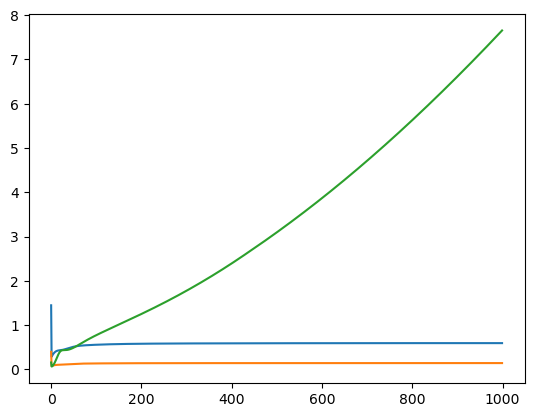

In [23]:
plt.plot(ys["ICG6P"])
plt.plot(ys["ICF6P"])
plt.plot(ys["ICFBP"])
# plt.plot(ys['ECETOH'])

In [83]:
# log_loss_func_GP1=jax.jit(create_log_params_means_centered_loss_func2(glycolyse_GP1,loss_targets_glucose_pulse))

loss_targets_glucose_pulse = [0, 1, 2, 4, 5, 6, 8, 10, 12, 13, 14, 20, 21, 22]


# log_loss_func_GP1=jax.jit(create_log_params_means_centered_loss_func2(glycolysis1,loss_targets_glucose_pulse))

Array(1.97361845, dtype=float64)